# Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
from fastai.tabular import *

In [0]:
from google.colab import *
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data

In [0]:
train_df = pd.read_csv("gdrive/My Drive/hackathon/dataset/train.csv", index_col=0, parse_dates=True)

In [0]:
train_df.shape

(919650, 20)

In [0]:
pd.set_option('display.max_columns', 100)
train_df.head()

,response,apt_type,apt_date,sent_time,send_time,net_hour,type,clinic,city,province,cli_zip,cli_area,cli_size,pat_id,family_id,fam,gender,age,pat_area,dist
0,1,recall,2017-09-18 13:00:00,2017-09-14 19:03:03,17:30:00,-48,Voice,20758,Moncton,NB,E1E4C9,Urban,1239,427789,291683,3,M,20,Urban,65.929
1,0,6mth-rc,2017-09-06 17:00:00,2017-08-31 18:00:54,18:00:00,-72,Voice,122500,Port Coquitlam,BC,V3B5Y9,Urban,691,172834,49762,4,M,20,Urban,4.104
2,0,endo,2017-05-02 18:00:00,2017-04-28 10:12:42,10:00:00,-48,Email,20153,Nanaimo,BC,V9T4B5,Urban,1168,132074,101158,4,M,15,Rural,9.246
3,0,productive,2018-05-30 09:10:00,2018-05-28 09:00:37,09:00:00,-48,SMS,122335,Casselman,ON,K0A1M0,Rural,3425,145832,39367,4,F,50,Rural,10.693
4,0,filling,2019-02-04 08:00:00,2019-01-31 15:14:07,11:00:00,-48,SMS,143632,Etobicoke,ON,M8W3V5,Urban,274,88996,82480,2,F,65,Urban,6.937


In [0]:
train_df.dtypes

response       int64
apt_type      object
apt_date      object
sent_time     object
send_time     object
net_hour       int64
type          object
clinic         int64
city          object
province      object
cli_zip       object
cli_area      object
cli_size       int64
pat_id         int64
family_id      int64
fam            int64
gender        object
age            int64
pat_area      object
dist         float64
dtype: object

# DF optimization

train_df.drop(["apt_id", "apt_type", "family_id", "type"], inplace=True, axis=1 )

train_df.response = train_df.response.astype("int8")
train_df.net_hour = train_df.net_hour.astype("int32")
train_df.cli_area = train_df.cli_area.map({"Urban": 1, "Rural": 0}).astype("int8")
train_df.cli_size = train_df.cli_size.astype("int16")
train_df.pat_id = train_df.pat_id.astype("int32")
train_df.fam = train_df.fam.astype("int8")
train_df.gender = train_df.gender.map({"M": 1, "F": 0}).astype("int8")
train_df.age = train_df.age.astype("int8")
train_df.pat_area = train_df.pat_area.map({"Urban": 1, "Rural": 0}).astype("int8")
train_df.dist = train_df.dist.astype("int8")

# Dates preprocessing

In [0]:
train_df.apt_date = pd.to_datetime(train_df.apt_date)
train_df.sent_time = pd.to_datetime(train_df.sent_time)

In [0]:
add_datepart(train_df, field_name="apt_date", time=True )
add_datepart(train_df, field_name="sent_time")
print("done")

done


In [0]:
train_df.columns

Index(['response', 'apt_type', 'send_time', 'net_hour', 'type', 'clinic',
       'city', 'province', 'cli_zip', 'cli_area', 'cli_size', 'pat_id',
       'family_id', 'fam', 'gender', 'age', 'pat_area', 'dist', 'apt_Year',
       'apt_Month', 'apt_Week', 'apt_Day', 'apt_Dayofweek', 'apt_Dayofyear',
       'apt_Is_month_end', 'apt_Is_month_start', 'apt_Is_quarter_end',
       'apt_Is_quarter_start', 'apt_Is_year_end', 'apt_Is_year_start',
       'apt_Hour', 'apt_Minute', 'apt_Second', 'apt_Elapsed', 'sent_timeYear',
       'sent_timeMonth', 'sent_timeWeek', 'sent_timeDay', 'sent_timeDayofweek',
       'sent_timeDayofyear', 'sent_timeIs_month_end',
       'sent_timeIs_month_start', 'sent_timeIs_quarter_end',
       'sent_timeIs_quarter_start', 'sent_timeIs_year_end',
       'sent_timeIs_year_start', 'sent_timeElapsed'],
      dtype='object')

# Model

In [0]:
valid_idx = list(range(int(len(train_df)*0.8), len(train_df)))

In [0]:
dep_var = "response"

exlude: 'type', 'hour', 'apt_Second', 'apt_Elapsed', 'sent_timeMinute', 'sent_timeSecond', 'sent_timeElapsed'

In [0]:
# apt
# clinic
# patient
# apt_date - preprocessed
# sent_time - preprocessed
cat_names = ['apt_type', 'send_time', 'net_hour', 'type',
             'clinic','city', 'province', 'cli_area', 
             'fam', 'gender', 'age', 'pat_area',
             'apt_Year', 'apt_Month', 'apt_Week', 'apt_Day', 'apt_Dayofweek', 'apt_Dayofyear', 'apt_Is_month_end','apt_Is_month_start', 'apt_Is_quarter_end', 'apt_Is_quarter_start','apt_Is_year_end', 'apt_Is_year_start', 'apt_Hour', 'apt_Minute',
             'sent_timeYear', 'sent_timeMonth','sent_timeWeek', 'sent_timeDay', 'sent_timeDayofweek', 'sent_timeDayofyear', 'sent_timeIs_month_end', 'sent_timeIs_month_start', 'sent_timeIs_quarter_end', 'sent_timeIs_quarter_start', 'sent_timeIs_year_end', 'sent_timeIs_year_start'] 

In [0]:
cont_names = ['dist', 'cli_size']

In [0]:
len(train_df.columns)

47

In [0]:
# test: number of variables + target
len(cat_names + cont_names) + 1

41

In [0]:
procs = [FillMissing, Categorify, Normalize]

In [0]:
data =  (TabularList.from_df(train_df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                    .split_by_idx(valid_idx)
                    .label_from_df(cols=dep_var)
                    .databunch())

In [0]:
data.batch_size = 128

In [0]:
data.show_batch(rows=5)

apt_type,send_time,net_hour,type,clinic,city,province,cli_area,fam,gender,age,pat_area,apt_Year,apt_Month,apt_Week,apt_Day,apt_Dayofweek,apt_Dayofyear,apt_Is_month_end,apt_Is_month_start,apt_Is_quarter_end,apt_Is_quarter_start,apt_Is_year_end,apt_Is_year_start,apt_Hour,apt_Minute,sent_timeYear,sent_timeMonth,sent_timeWeek,sent_timeDay,sent_timeDayofweek,sent_timeDayofyear,sent_timeIs_month_end,sent_timeIs_month_start,sent_timeIs_quarter_end,sent_timeIs_quarter_start,sent_timeIs_year_end,sent_timeIs_year_start,dist,cli_size,target
rc,11:00:00,-48,SMS,121160,Dartmouth,NS,Urban,1,F,55,Urban,2019,2,6,6,2,37,False,False,False,False,False,False,16,50,2019,2,6,4,0,35,False,False,False,False,False,False,-0.3033,0.9340,1
general,09:00:00,-336,SMS,122631,Toronto,ON,Urban,1,M,50,Urban,2019,1,4,22,1,22,False,False,False,False,False,False,13,0,2019,1,2,9,2,9,False,False,False,False,False,False,-0.3215,-0.1113,0
general,11:30:00,-72,SMS,121878,Edmonton,AB,Urban,1,F,90,Urban,2017,11,48,29,2,333,False,False,False,False,False,False,10,0,2017,11,47,25,5,329,False,False,False,False,False,False,-0.4231,-0.5521,0
filling,12:00:00,-48,SMS,133492,Brandon,MB,Urban,1,M,15,Rural,2019,1,3,17,3,17,False,False,False,False,False,False,12,0,2019,1,3,15,1,15,False,False,False,False,False,False,5.1981,-1.1686,1
sc,08:00:00,-144,SMS,122621,Niagara Falls,ON,Urban,1,F,65,Urban,2017,5,22,29,0,149,False,False,False,False,False,False,17,20,2017,5,21,23,1,143,False,False,False,False,False,False,0.2701,-0.6557,1


# Training

In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [0]:
learn.fit(8, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.587065,0.586909,0.678258,02:17
1,0.582456,0.598806,0.677046,02:19
2,0.582268,0.733969,0.677524,02:18
3,0.586246,0.597792,0.680416,02:20
4,0.587333,0.587164,0.678345,02:19
5,0.588315,0.586427,0.679084,02:19
6,0.585886,0.584919,0.680400,02:18
7,0.580283,0.719474,0.680862,02:19


## Saving

In [0]:
learn.save("em-model09")

In [0]:
learn.export("models/em-model10-exp")

## Saving to drive

In [0]:
######################## ZIP AND UPLOAD FOLDER TO DRIVE ########################

!pip install -U -q PyDrive

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import os
import sys

zipname = 'model_09'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/models/')

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

## Loading from drive

In [0]:
#################### DOWNLOAD AND UNZIP FILE SAVED IN DRIVE ####################

!pip install -U -q PyDrive

# HERE YOUR FILE ID ( GET IT WITH THE SHARING URL: https://drive.google.com/open?id=1XpV73Ebyg5Qjif2uXwaZ-I17F9uRAZNW )
zip_id = '1XpV73Ebyg5Qjif2uXwaZ-I17F9uRAZNW'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('models'):
    os.makedirs('models')

# DOWNLOAD ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('model.zip')



    100% |████████████████████████████████| 993kB 22.4MB/s 


In [0]:
# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall('models/')
zip_ref.close()

Uncompressing zip file


In [0]:
learn.load("em-model09")

Learner(data=TabularDataBunch;

Train: LabelList (840109 items)
x: TabularList
apt_type general; send_time 09:00:00; net_hour -72; type Email; clinic 122328; city Kanata; province ON; cli_zip K2K1X7; cli_area Urban; fam 1; gender F; age 65; pat_area Urban; apt_Year 2018; apt_Month 8; apt_Week 34; apt_Day 23; apt_Dayofweek 3; apt_Dayofyear 235; apt_Is_month_end False; apt_Is_month_start False; apt_Is_quarter_end False; apt_Is_quarter_start False; apt_Is_year_end False; apt_Is_year_start False; apt_Hour 13; apt_Minute 0; sent_timeYear 2018; sent_timeMonth 8; sent_timeWeek 34; sent_timeDay 20; sent_timeDayofweek 0; sent_timeDayofyear 232; sent_timeIs_month_end False; sent_timeIs_month_start False; sent_timeIs_quarter_end False; sent_timeIs_quarter_start False; sent_timeIs_year_end False; sent_timeIs_year_start False; dist 0.1139; cli_size -0.8756; ,apt_type general; send_time 08:00:00; net_hour -24; type Email; clinic 122359; city Toronto; province ON; cli_zip M5N1A7; cli_area Urban; fam 

#Test data - preprocessing

In [0]:
test_df = pd.read_csv("gdrive/My Drive/hackathon/dataset/test.csv", index_col=0, parse_dates=True)

In [0]:
test_df.head()

,apt_type,apt_date,sent_time,send_time,net_hour,type,clinic,city,province,cli_zip,cli_area,cli_size,pat_id,family_id,fam,gender,age,pat_area,dist
0,rm1r/c,2018-12-03 08:00:00,2018-11-29 08:05:13,08:00:00,-48,Email,120956,Sidney,BC,V8L1Y2,Urban,3150,986691,395713,4,F,45,Urban,4.497
1,general,2018-04-11 15:30:00,2018-04-07 10:00:07,11:00:00,-72,Email,123294,Toronto,ON,M4K1R2,Urban,5267,148198,136097,5,M,10,Urban,0.314
2,rc -*9acc,2018-05-03 13:30:00,2018-05-01 08:01:28,08:00:00,-48,Email,121777,Stayner,ON,L0M1S0,Rural,2536,281866,242299,1,F,75,Rural,54.467
3,general,2019-01-12 09:00:00,2019-01-05 11:01:08,11:00:00,-168,SMS,122192,Edmonton,AB,T6C1M3,Urban,2864,144658,133076,1,F,60,Urban,5.909
4,general,2018-06-22 10:15:00,2018-06-20 08:30:23,09:00:00,-48,Voice,122980,Niagara Falls,ON,L2E6M9,Urban,4277,647998,121629,3,F,60,Urban,1.193


In [0]:
add_datepart(test_df, field_name="apt_date", time=True )
add_datepart(test_df, field_name="sent_time", time=True )
print('done')

done


# Prediction

In [0]:
testdata = TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names, procs=procs)

In [0]:
learn = load_learner(path="models/", fname="em-model10-exp", test=testdata)


In [0]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
len(preds)

91310

In [0]:
response = np.argmax(preds.numpy(), axis=1)

In [0]:
response

array([1, 0, 0, 0, ..., 1, 0, 1, 1])

In [0]:
pd.DataFrame(response).to_csv('gdrive/My Drive/hackathon/predictions/em-model05.csv', index=False)

# Evaluation

In [0]:
test_y_df = pd.read_csv("gdrive/My Drive/hackathon/dataset/test_y.csv", index_col=0)

In [0]:
test_y_df.head()

,response
0,0
1,0
2,0
3,1
4,0


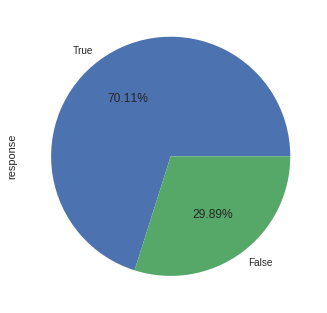

In [0]:
(response == test_y_df['response']).value_counts().plot.pie(autopct='%1.2f%%');

# Deployment

## Reminder

In [0]:
# reminder 
test_df.iloc[0].to_frame().transpose()

,apt_type,send_time,net_hour,type,clinic,city,province,cli_zip,cli_area,cli_size,pat_id,family_id,fam,gender,age,pat_area,dist,apt_Year,apt_Month,apt_Week,apt_Day,apt_Dayofweek,apt_Dayofyear,apt_Is_month_end,apt_Is_month_start,apt_Is_quarter_end,apt_Is_quarter_start,apt_Is_year_end,apt_Is_year_start,apt_Hour,apt_Minute,apt_Second,apt_Elapsed,sent_timeYear,sent_timeMonth,sent_timeWeek,sent_timeDay,sent_timeDayofweek,sent_timeDayofyear,sent_timeIs_month_end,sent_timeIs_month_start,sent_timeIs_quarter_end,sent_timeIs_quarter_start,sent_timeIs_year_end,sent_timeIs_year_start,sent_timeHour,sent_timeMinute,sent_timeSecond,sent_timeElapsed
0,rm1r/c,08:00:00,-48,Email,120956,Sidney,BC,V8L1Y2,Urban,3150,986691,395713,4,F,45,Urban,4.497,2018,12,49,3,0,337,False,False,False,False,False,False,8,0,0,1543824000,2018,11,48,29,3,333,False,False,False,False,False,False,8,5,13,1543478713


In [0]:
# reminder - processed data for the model
reminder = testdata[0]
reminder

apt_type                         rm1r/c
send_time                      08:00:00
net_hour                            -48
type                              Email
clinic                           120956
city                             Sidney
province                             BC
cli_zip                          V8L1Y2
cli_area                          Urban
cli_size                       0.191853
pat_id                           986691
family_id                        395713
fam                                   4
gender                                F
age                                  45
pat_area                          Urban
dist                          -0.297604
apt_Year                           2018
apt_Month                            12
apt_Week                             49
apt_Day                               3
apt_Dayofweek                         0
apt_Dayofyear                       337
apt_Is_month_end                  False
apt_Is_month_start                False


In [0]:
# reminder - prediction
learn.predict(reminder)

(Category 1, tensor(1), tensor([0.4579, 0.5421]))

In [0]:
# reminder - probability of confirming
learn.predict(reminder)[2].numpy()[1]

0.5421342

## Probabilities - types of reminders

In [0]:
test_df.type.unique()


array(['Email', 'SMS', 'Voice'], dtype=object)

In [0]:
test_copy = test_df.copy()

In [0]:
for t in test_copy.type.unique():
  test_copy.loc[test_copy.index == 0, "type"] = t
  testdata = TabularList.from_df(test_copy, cat_names=cat_names, cont_names=cont_names, procs=procs)
  reminder = testdata[0]
  print(t, learn.predict(reminder)[2].numpy()[1])

Email 0.5355852
SMS 0.7066814
Voice 0.74154615


## Probabilities - send_time                      

In [0]:
print(sorted(test_df.send_time.unique()))

['00:00:00', '07:00:00', '07:30:00', '08:00:00', '08:15:00', '08:30:00', '08:31:00', '08:45:00', '09:00:00', '09:30:00', '10:00:00', '10:30:00', '11:00:00', '11:30:00', '11:45:00', '12:00:00', '12:30:00', '12:45:00', '13:00:00', '13:30:00', '14:00:00', '14:30:00', '15:00:00', '15:30:00', '16:00:00', '16:30:00', '17:00:00', '17:15:00', '17:17:00', '17:20:00', '17:30:00', '17:40:00', '17:45:00', '18:00:00', '18:10:00', '18:30:00', '18:40:00', '19:00:00']


In [0]:
test_copy = test_df.copy()

In [0]:
for st in sorted(test_df.send_time.unique()):
  test_copy.loc[test_copy.index == 0, "send_time"] = st
  testdata = TabularList.from_df(test_copy, cat_names=cat_names, cont_names=cont_names, procs=procs)
  reminder = testdata[0]
  print(st, learn.predict(reminder)[2].numpy()[1])

00:00:00 0.539507
07:00:00 0.53251153
07:30:00 0.5316631
08:00:00 0.5355852
08:15:00 0.53500766
08:30:00 0.54299814
08:31:00 0.53881127
08:45:00 0.5398257
09:00:00 0.5412592
09:30:00 0.5392866
10:00:00 0.53826284
10:30:00 0.53643227
11:00:00 0.540196
11:30:00 0.53550303
11:45:00 0.5377774
12:00:00 0.535502
12:30:00 0.5400007
12:45:00 0.537747
13:00:00 0.53908265
13:30:00 0.53573555
14:00:00 0.53768
14:30:00 0.5376556
15:00:00 0.54325604
15:30:00 0.53780025
16:00:00 0.53447443
16:30:00 0.5427816
17:00:00 0.5337724
17:15:00 0.5377341
17:17:00 0.5388052
17:20:00 0.53529984
17:30:00 0.5381505
17:40:00 0.53438824
17:45:00 0.53880763
18:00:00 0.5391576
18:10:00 0.53749424
18:30:00 0.53396374
18:40:00 0.53230983
19:00:00 0.5020576


## Best

In [0]:
best = {}

In [0]:
test_copy = test_df.copy()

In [0]:
for t in test_copy.type.unique():
  test_copy.loc[test_copy.index == 0, "type"] = t
  for st in sorted(test_df.send_time.unique()):
    test_copy.loc[test_copy.index == 0, "send_time"] = st
    testdata = TabularList.from_df(test_copy, cat_names=cat_names, cont_names=cont_names, procs=procs)
    reminder = testdata[0]
    best[(learn.predict(reminder)[2].numpy()[1])] = [t,st]

In [0]:
# top 50: type, send_time
for key in sorted(best.keys(), reverse=True)[:50]:
  print(key, best[key])

0.7874367 ['Voice', '16:00:00']
0.7810357 ['Voice', '17:30:00']
0.77827936 ['Voice', '17:17:00']
0.77149856 ['Voice', '08:45:00']
0.76646775 ['Voice', '08:30:00']
0.76378125 ['Voice', '17:15:00']
0.7634017 ['Voice', '12:30:00']
0.76182216 ['Voice', '15:00:00']
0.75982475 ['Voice', '14:30:00']
0.7582262 ['Voice', '17:20:00']
0.7570762 ['Voice', '14:00:00']
0.7560867 ['Voice', '18:00:00']
0.75531137 ['Voice', '09:00:00']
0.7551773 ['Voice', '18:40:00']
0.75504756 ['Voice', '09:30:00']
0.75481504 ['Voice', '08:31:00']
0.7544949 ['Voice', '18:30:00']
0.7540794 ['Voice', '16:30:00']
0.7540203 ['Voice', '18:10:00']
0.7534699 ['Voice', '17:40:00']
0.7502682 ['Voice', '12:45:00']
0.7489001 ['Voice', '17:45:00']
0.7487121 ['Voice', '17:00:00']
0.7454698 ['Voice', '10:00:00']
0.7451533 ['Voice', '11:00:00']
0.7439784 ['Voice', '15:30:00']
0.7432715 ['Voice', '13:00:00']
0.74226725 ['Voice', '13:30:00']
0.74154615 ['Voice', '08:00:00']
0.7412284 ['Voice', '07:00:00']
0.7409609 ['SMS', '12:30:00']